In [51]:
import pandas as pd
from genepeeks.common import utilities as util
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tabletext
from scipy.stats import poisson

#### Add poisson values to PEM contingency table since scipy.stats could not be imported on amazon instance

In [123]:
initial_df = pd.read_csv("../exon_data/PEM_contingency_table_initial.csv", header=1)

cutoff_fraction = 0.01
headers = []
final_contingency_table = []
exon_fields = ['total', 'lower_outl', 'lower_poisson', 'upper_outl', 'upper_poisson']
for i, header in enumerate(initial_df.columns):
    if not header.startswith('Ex'):
        if i != 0:
            headers.append(header)
        for subj_i, item in enumerate(initial_df[header]):
            if i == 0:
                final_contingency_table.append([])
            else:
                final_contingency_table[subj_i].append(item)
    if header.endswith('total'):
        exon = header.split('_')[0]
        for field in exon_fields:
            headers.append('{}_{}'.format(exon, field))
        
        exon_values = zip(initial_df[header], initial_df[initial_df.columns[i + 1]], initial_df[initial_df.columns[i + 2]])
        for subj_i, (total, lower, upper) in enumerate(exon_values):
            expected = total * cutoff_fraction
            lower_poisson = 1.0 - poisson.cdf(lower, expected)
            upper_poisson = 1.0 - poisson.cdf(upper, expected)

            subj_exon_stats = [total, lower, lower_poisson, upper, upper_poisson]
            final_contingency_table[subj_i] += subj_exon_stats
            
final_contingency_table.insert(0, headers)

# Convert to pandas data frame and export to csv
final_df = pd.DataFrame(final_contingency_table)
final_df.to_csv("../exon_data/PEM_contingency_table_final.csv")

#### Load final contingency table from csv as pandas dataframe, and filter out old subjects if requested

In [124]:
final_df = pd.read_csv("../exon_data/PEM_contingency_table_final.csv", header=1)

# If requested, only look at subjects that were not from the initial batch of created subjects
only_new_subjects = True
relevant_df = final_df[final_df['date_modified'] > 1465401045] if only_new_subjects else final_df

#### Look at the number of subjects with low p values for each exon

┌─────────┬────────────────────────┬────────────────────────┬────────────────────────┬────────────────────────┐
│ Exon    │ Count with CDF < 1e-05 │ Count with CDF < 1e-06 │ Count with CDF < 1e-07 │ Count with CDF < 1e-08 │
├─────────┼────────────────────────┼────────────────────────┼────────────────────────┼────────────────────────┤
│ Ex1     │                      0 │                      0 │                      0 │                      0 │
├─────────┼────────────────────────┼────────────────────────┼────────────────────────┼────────────────────────┤
│ Ex2     │                      0 │                      0 │                      0 │                      0 │
├─────────┼────────────────────────┼────────────────────────┼────────────────────────┼────────────────────────┤
│ Ex3     │                      0 │                      0 │                      0 │                      0 │
├─────────┼────────────────────────┼────────────────────────┼────────────────────────┼──────────────────

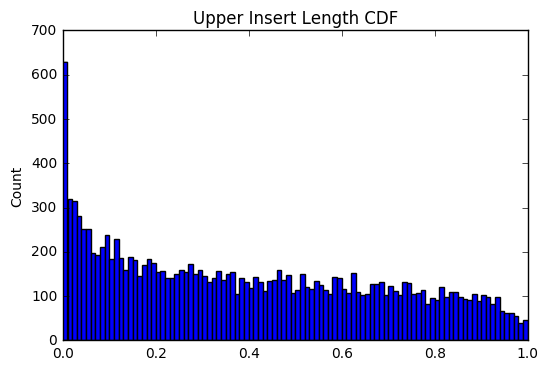

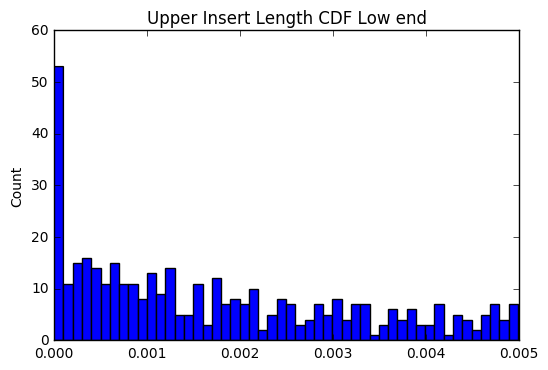

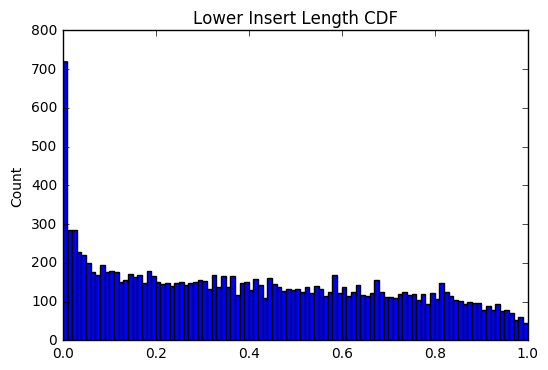

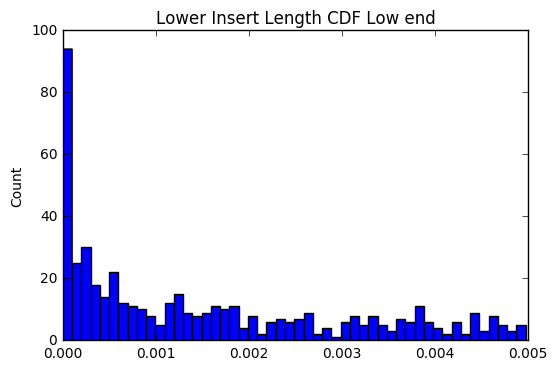

In [101]:
p_val_cutoffs = [0.00001, 0.000001, 0.0000001, 0.00000001]
headers = ['Exon'] + ['Count with p < {}'.format(cutoff) for cutoff in p_val_cutoffs]
exon_low_p_val_count = [headers]
all_p_values = {'Lower': [], 'Upper': []}

for i, col in enumerate(relevant_df.columns):
    if 'upper_poisson' in col:
        exon = col.split('_')[0]
        exon_upper_poisson = relevant_df[col]
        all_p_values['Upper'] += list(exon_upper_poisson)
        all_p_values['Lower'] += list(relevant_df[relevant_df.columns[i-2]])
        exon_data = [exon] + [len(filter(lambda x: x < cutoff, exon_upper_poisson)) for cutoff in p_val_cutoffs]
        exon_low_p_val_count.append(exon_data)
        
#         plt.hist(upper_list, bins=50)
#         plt.title("{} Insert Length CDF".format(exon))
#         plt.ylabel("Count")
#         plt.show()
        
print tabletext.to_text(exon_low_p_val_count)

# Plot histograms of all the p_values
for outl_side, p_values in all_p_values.items():
    plt.hist(p_values, bins=100)
    plt.title("{} Insert Length CDF".format(outl_side))
    plt.ylabel("Count")
    plt.show()

    clipped_p_values = [item for item in p_values if item < 0.005]
    plt.hist(clipped_p_values, bins=50)
    plt.title("{} Insert Length CDF Low end".format(outl_side))
    plt.ylabel("Count")
    plt.show()


#### Look at the number of exons with low p values for each subject

In [119]:
headers = ['Subject'] + ['Exons with p < {}'.format(cutoff) for cutoff in p_val_cutoffs]
subject_outlier_counts = [headers]
for subject_i in xrange(final_df.shape[0]):
    subject_data = final_df.iloc[subject_i]
    # Filter out old subjects
    if subject_data['date_modified'] < 1465401045:
        continue
    upper_poisson_values = subject_data.filter(regex=('upper_poisson'))
    subject_stats = [final_df['subject'][subject_i]] + [len(filter(lambda x: x < cutoff, upper_poisson_values)) for cutoff in p_val_cutoffs]
    if subject_stats[2]:
        subject_outlier_counts.append(subject_stats)
print tabletext.to_text(subject_outlier_counts)

┌────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┐
│ Subject        │ Exons with p < 1e-05 │ Exons with p < 1e-06 │ Exons with p < 1e-07 │ Exons with p < 1e-08 │
├────────────────┼──────────────────────┼──────────────────────┼──────────────────────┼──────────────────────┤
│ FPFC-JABH-UI96 │                    2 │                    2 │                    2 │                    1 │
├────────────────┼──────────────────────┼──────────────────────┼──────────────────────┼──────────────────────┤
│ FGPC-IVLC-WFZD │                    1 │                    1 │                    1 │                    1 │
├────────────────┼──────────────────────┼──────────────────────┼──────────────────────┼──────────────────────┤
│ FPWB-0001-315V │                    2 │                    1 │                    1 │                    0 │
├────────────────┼──────────────────────┼──────────────────────┼──────────────────────┼──────────────────────┤
│

#### Examine recent subjects that had too many outliers in Exon 33 (examining false positives)

In [122]:
final_df[(final_df['Ex33_upper_poisson'] < 0.00001) & (final_df['date_modified'] > 1465401045)].filter(regex=('Ex33|subject|cutoff')).sort_values(by='Ex33_upper_outl', ascending=False)


,subject,Ex33_total,Ex33_lower_outl,Ex33_lower_poisson,Ex33_upper_outl,Ex33_upper_poisson
173,FGPC-IVLC-WFZD,215,3,0.170907,14,9.963701e-09
